In [23]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from galaxybrain import ramsey, ising
from galaxybrain.plot_utils import rc_style, pltlabel, plot_ising_spectra, line_corr, TEMP_COLOR_RANGE
rc_style()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as lcmap
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ising model and scaling correlation analysis
Hamiltonian – rate of change in time of the condition of a dynamic physical system, or total energy in the system – is given by

\\[ H = -J\sum_{ij} s_is_j \\] 

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Furnstahl:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

References:
- https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf

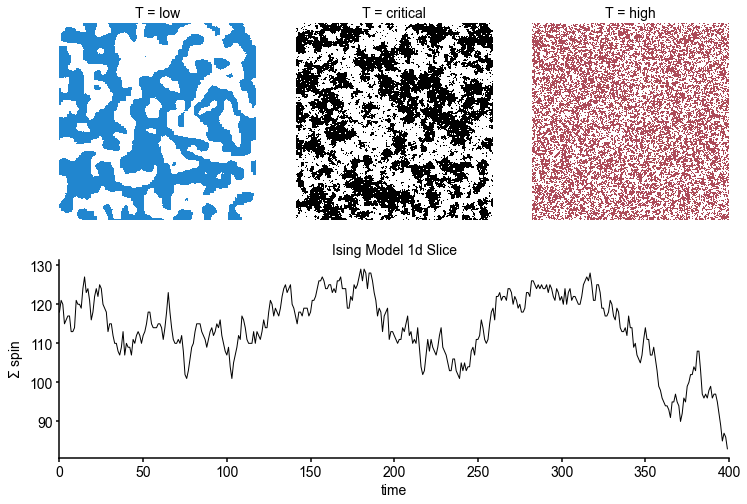

In [19]:
from matplotlib.gridspec import GridSpec


cs = TEMP_COLOR_RANGE[0], 'k', TEMP_COLOR_RANGE[1] #cold, crit, hot
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,3)
for (i, temp), c in zip(enumerate([0.1, 'critical', 5]), cs):
    # plt.subplot(1,3,i+1)
    ax = fig.add_subplot(gs[0,i])
    grid = ising.metro_ising(N=256, T=temp, runtime=500)
    ax.imshow(grid[499], cmap=lcmap(['w',c])) # plot last frame
    title_map = {0.1:'low', 'critical':'critical', 5:'high'}
    plt.title(f'T = {title_map[temp]}', fontsize=14)
    ax.axis('off')
    if temp == 'critical':
        ax = fig.add_subplot(gs[1,:])
        ising_raster_slice = pd.DataFrame(grid[100:][:,178]) # shape (400, 256)

        ax.plot(np.sum(ising_raster_slice.T), c, lw=1)
        plt.xlim([0,400])
        pltlabel('Ising Model 1d Slice', 'time', r'$\Sigma$ spin')
    
plt.savefig('../fig/ising/grid_samples.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Data from cluster

Iterated 5 times for each temperature in: 0.50, 1.00, 1.27, 1.47, 1.67, 1.87, 2.07, 2.27, 2.47, 2.67, 2.87, 3.07, 3.27, 5.00

In [20]:
from galaxybrain.data_utils import load_results

sim_data = load_results('../data/experiments/expSIM2', kind='sim')

{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}


In [40]:
plot_ising_spectra(sim_data, sample_temps, temps)


KeyError: 1.67

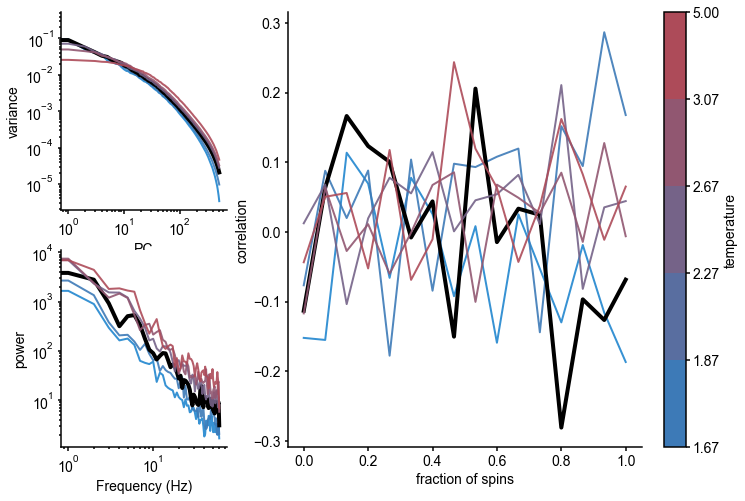

In [55]:
sample_temps = ['1.67', '1.87', '2.27', '2.67', '3.07', '5.00'] # avoid big drop off with very low temps

fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,2, width_ratios=[1.5,4])
# temps = [k for k in sim_data if k != 'meta']


for (i, spec), labels in zip(enumerate(['eigs', 'pows']), 
                           [['','PC', 'variance'], ['','Frequency (Hz)', 'power']]):
    ax = fig.add_subplot(gs[i, 0])
    plot_ising_spectra(sim_data, spec, sample_temps, ax=ax)
    pltlabel(*labels)
    
corr_mat = np.array([sim_data[t]['data']['pearson_corr'].mean(0) for t in sample_temps])
temps = list(map(float, sample_temps))
ax = fig.add_subplot(gs[:,1])
line_corr(corr_mat, temps, ax)


# plt.savefig('../fig/ising/psd_sample.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# summary heatmap

# summary line plot
### iterated over temps, fraction of neuron on x axis

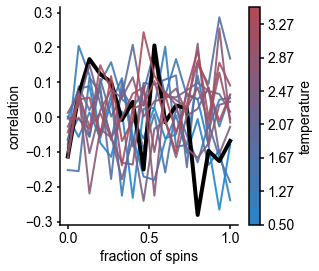

In [5]:

line_corr(corr_mat, temps)
# plt.savefig('../fig/ising/corr_plot_temp.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

### iterated over fraction of neuron, temps on x axis

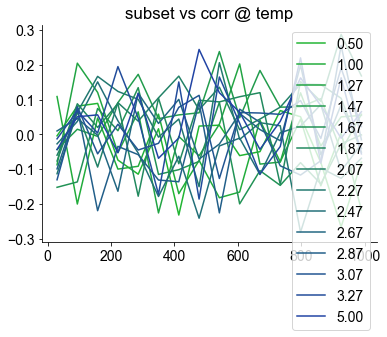

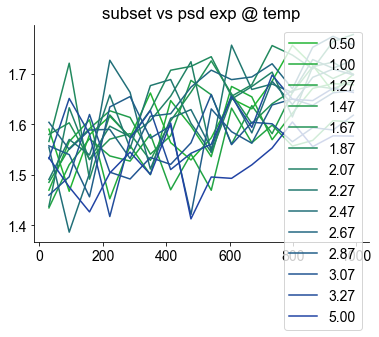

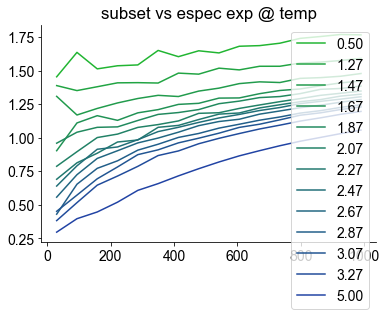

In [39]:
from matplotlib.colors import LinearSegmentedColormap

subset_sizes = sim_data['1.00']['meta']['subsetsizes'] #arbitrary temperature
cmap = LinearSegmentedColormap.from_list('mycmap', ['#21b532', '#2132b5'])(np.linspace(0, 1, len(subset_sizes)))
for i, temp in enumerate(sim_data.keys()):
    plt.plot(subset_sizes, sim_data[temp]['data']['pearson_corr'].mean(0), color=cmap[i], label=temp)
pltlabel('subset vs corr @ temp', '','')
plt.legend()

plt.figure()
for i, temp in enumerate(sim_data.keys()):
    plt.plot(subset_sizes, sim_data[temp]['data']['psd_exp'][0], color=cmap[i], label=temp)
pltlabel('subset vs psd exp @ temp','','')
plt.legend()

plt.figure()
for i, temp in enumerate(sim_data.keys()):
    if temp == '1.00': continue # this one is messed up for some reason
    plt.plot(subset_sizes, sim_data[temp]['data']['espec_exp'][0], color=cmap[i], label=temp)
pltlabel('subset vs espec exp @ temp','','')
plt.legend()